## d2armor - Analyze all armor in your Destiny 2 vault 

A python jupyter notebook that can analyze all armor in your Destiny 2 vault and tell you what is great and what is worth sharding.

This notebook assumes that your vault information has already been downloaded into `data/profile.json` via the `d2profile.ipynb` jupyter notebook.

In [1]:
# use the data/profile.json downloaded by `d2profile.ipynb` to load your profile containing all armor and weapons
import os
import json

os.makedirs("data", exist_ok=True)

# assert that the json files exist
assert os.path.exists(
    "data/profile.json"
), "Profile file not found. Run the d2profile.ipynb notebook first to generate it."
assert os.path.exists(
    "data/item_definitions.json"
), "Item definitions file not found. Run the d2profile.ipynb notebook first to generate it."
assert os.path.exists(
    "data/stat_definitions.json"
), "Stat definitions file not found. Run the d2profile.ipynb notebook first to generate it."

with open("data/profile.json", "r") as file:
    profile = json.load(file)

print("Character profile loaded at:", profile["responseMintedTimestamp"])

with open("data/item_definitions.json", "r") as file:
    item_definitions = json.load(file)

with open("data/stat_definitions.json", "r") as file:
    stat_definitions = json.load(file)

Character profile loaded at: 2024-06-03T04:34:33.988Z


In [2]:
# extract all armor pieces out of the profile.  It retrieves from the vault, character inventory, and character equipment
from src.armor import ProfileArmor
import pandas as pd

profile_armor = ProfileArmor(profile, item_definitions, stat_definitions)

armor_dict = profile_armor.get_armor_dict()

armor_df = pd.DataFrame(
    [
        {
            **vars(armor),
            "total_stats": armor.total_stats,
            "is_exotic": armor.is_exotic,
            "class_slot": armor.class_slot,
        }
        for armor in armor_dict.values()
    ]
)

armor_df

,item_name,item_hash,instance_id,rarity,slot,power,mobility,resilience,recovery,discipline,intellect,strength,is_artifice,is_masterworked,d2_class,total_stats,is_exotic,class_slot
0,Tusked Allegiance Helmet,2240729575,6917529815104854677,Legendary,Helmet,1810,2,23,7,21,10,2,False,True,Titan,65,False,Titan Helmet
1,Synthoceps,241462142,6917529871224003792,Exotic,Gauntlets,1810,2,17,14,17,2,10,False,True,Titan,62,True,Titan Gauntlets
2,Warmind's Avatar Chestplate,839296981,6917529857906618905,Legendary,Chest Armor,1810,2,30,2,15,10,6,False,True,Titan,65,False,Titan Chest Armor
3,Ketchkiller's Greaves,1640403802,6917529823402521839,Legendary,Leg Armor,1809,6,22,6,23,8,2,False,True,Titan,67,False,Titan Leg Armor
4,Descending Echo Mark,4050474396,6917529942979833410,Legendary,Class Item,1810,0,0,0,0,0,0,True,True,Titan,0,False,Titan Class Item
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,Hinterland Vest,2923110818,6917529960103865660,Legendary,Chest Armor,1800,20,12,2,16,2,13,False,False,Hunter,65,False,Hunter Chest Armor
299,Eternal Warrior,2808156426,6917529834873405734,Exotic,Helmet,1600,2,15,17,17,12,2,False,False,Titan,65,True,Titan Helmet
300,Contraverse Hold,1906093346,6917529936709740897,Exotic,Gauntlets,1810,2,30,4,28,2,2,False,True,Warlock,68,True,Warlock Gauntlets
301,Techeun's Regalia Robes,988330314,6917530015482269735,Legendary,Chest Armor,1800,24,2,7,2,23,8,False,False,Warlock,66,False,Warlock Chest Armor


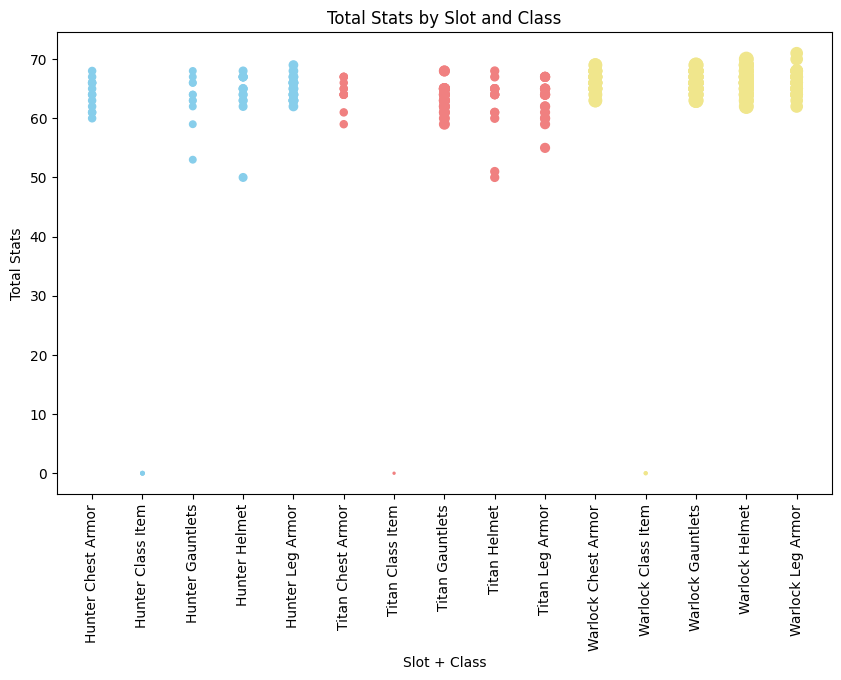

In [3]:
# create a graph that shows total stats by class and slot for all armor in the vault.  The larger the circle, the more we have with that stat total
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Sort by class slot:
armor_df.sort_values("class_slot", ascending=True, inplace=True)

# Create a color map for the classes
color_map = {
    "Hunter": mcolors.CSS4_COLORS["skyblue"],
    "Titan": mcolors.CSS4_COLORS["lightcoral"],
    "Warlock": mcolors.CSS4_COLORS["khaki"],
}
armor_df["color"] = armor_df["d2_class"].map(color_map)

# Calculate the counts for each 'class_slot' value
counts = armor_df["class_slot"].value_counts()

plt.figure(figsize=(10, 6))
# Pass the counts as the 's' argument to plt.scatter()
plt.scatter(
    armor_df["class_slot"],
    armor_df["total_stats"],
    s=counts[armor_df["class_slot"]] * 2,
    color=armor_df["color"],
)
plt.xlabel("Slot + Class")
plt.ylabel("Total Stats")
plt.title("Total Stats by Slot and Class")
plt.xticks(rotation=90)
plt.show()

### Create ProfileOutfits which will let us calcuate permutations of all outfits in our vault

In [4]:
from src.armor import ProfileOutfits

# uncomment if we want to see only armor that isn't exotic
# non_exotic_armor_dict = {k: v for k, v in armor_dict.items() if not v.is_exotic}
# profile_outfits = ProfileOutfits(non_exotic_armor_dict)

# or uncomment this to use all armor in the vault
profile_outfits = ProfileOutfits(armor_dict)

### Identify all armor that is eclipsed by another piece of armor and can be safely deleted

In [5]:
# print out all armor that has the same or worse stats than another piece of armor of the same rarity and type
for lesser_armor, greater_armor in profile_outfits.find_eclipsed_armor():
    print(f"id:{lesser_armor.instance_id} OR id:{greater_armor.instance_id}")
    print(
        f"mob {lesser_armor.mobility}\tres {lesser_armor.resilience}\trec {lesser_armor.recovery}\tdis {lesser_armor.discipline}\tint {lesser_armor.intellect}\tstr {lesser_armor.strength}\t name {lesser_armor.item_name} <-- can be deleted"
    )
    print(
        f"mob {greater_armor.mobility}\tres {greater_armor.resilience}\trec {greater_armor.recovery}\tdis {greater_armor.discipline}\tint {greater_armor.intellect}\tstr {greater_armor.strength}\t name {greater_armor.item_name} <-- is equal or better"
    )

### Generate all possible outfits for each class type

In [6]:
# generate outfit permutations for each class
d2_class = "Hunter"
hunter_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(hunter_outfits)} outfit permutations for {d2_class}")

d2_class = "Titan"
titan_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(titan_outfits)} outfit permutations for {d2_class}")

d2_class = "Warlock"
warlock_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(warlock_outfits)} outfit permutations for {d2_class}")

Generated 37328 outfit permutations for Hunter
Generated 45028 outfit permutations for Titan
Generated 9284274 outfit permutations for Warlock


## Pick a class to work with for the rest of the notebook

In [7]:
# modify to the class you want to work with below
# d2_class, outfits = ("Hunter", hunter_outfits)
# d2_class, outfits = ("Titan", titan_outfits)
d2_class, outfits = ("Warlock", warlock_outfits)

In [8]:
# given the outfit permutations above PinnacleOutfits will generate a dataframe with weighted stats for each outfit
# this lets us see which armor pieces are in outfits that are "pinnacle" (have the highest total stats for a given stat combination)
from src.armor import PinnacleOutfits

pinnacle_outfits = PinnacleOutfits(outfits)
weighted_outfits_df = pinnacle_outfits.weighted_outfits_df
weighted_outfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_intellect_max,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
40,70,40,90,30,30,6917529862437575151,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,-1,4,340,370,340,390,330,330,410,380,430,370,370,410,460,400,400,430,370,370,420,420,360,450,500,440,…,420,430,480,480,520,520,520,480,530,520,520,530,520,530,480,480,480,510,580,560,570,570,560,570,560,570,560,580,560,570,580,570,570,570,580,560,500
40,70,40,90,40,30,6917529862437575151,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,-1,4,350,380,350,400,350,340,420,390,440,390,380,420,470,420,410,440,390,380,440,430,380,460,510,460,…,420,430,480,480,520,520,520,480,530,520,520,530,520,530,480,480,480,510,580,560,570,570,560,570,560,570,560,580,560,570,580,570,570,570,580,560,500
50,70,40,90,30,30,6917529862437575151,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,-1,4,360,380,350,400,340,340,430,400,450,390,390,420,470,410,410,440,380,380,430,430,370,470,520,460,…,420,430,480,480,520,520,520,480,530,520,520,530,520,530,480,480,480,510,580,560,570,570,560,570,560,570,560,580,560,570,580,570,570,570,580,560,500
40,80,40,90,30,40,6917529862437575151,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,-1,4,360,400,360,410,350,360,440,400,450,390,400,440,490,430,440,450,390,400,440,450,390,480,530,470,…,420,430,480,480,520,520,520,480,530,520,520,530,520,530,480,480,480,510,580,560,570,570,560,570,560,570,560,580,560,570,580,570,570,570,580,560,500
40,80,40,90,30,30,6917529862437575151,6917529

In [9]:
# finds the max value in each of the "weighted" columns grouped by num_artifice, then filter to those rows
weighted_outfits_max_df = pinnacle_outfits.weighted_outfits_max_df
weighted_outfits_max_df

exotic_hash,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,weighted_mobility_resilience_strength,weighted_mobility_recovery_discipline,weighted_mobility_recovery_intellect,weighted_mobility_recovery_strength,weighted_mobility_discipline_intellect,weighted_mobility_discipline_strength,weighted_mobility_intellect_strength,weighted_resilience_recovery_discipline,weighted_resilience_recovery_intellect,weighted_resilience_recovery_strength,weighted_resilience_discipline_intellect,weighted_resilience_discipline_strength,weighted_resilience_intellect_strength,weighted_recovery_discipline_intellect,weighted_recovery_discipline_strength,weighted_recovery_intellect_strength,weighted_discipline_intellect_strength
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3259193988,100,100,100,100,100,100,6917530017559095794,6917529947325340314,6917530017562580867,6917530017562578907,6917529583788947730,4,410,420,420,420,420,420,460,460,490,500,500,480,500,510,510,500,510,520,460,460,470,500,550,540,540,540,550,550,540,530,550,550,550,560,560,540,560,550,550,560,500
3381022969,100,100,100,100,100,100,6917529856623937918,6917530017562582148,6917530017562580867,6917530017562578907,6917529583788947730,4,420,430,420,430,420,430,480,470,520,500,500,480,530,500,530,510,500,510,480,480,460,500,580,550,560,560,550,550,560,560,540,580,550,570,570,580,560,550,560,540,500
2950045886,100,100,100,100,100,100,6917530017559095794,6917529945432039255,6917530017562580867,6917530017562578907,6917529583788947730,4,430,430,430,430,420,430,480,480,520,510,510,480,530,520,520,530,510,510,480,480,470,500,580,560,560,570,540,560,570,560,550,570,560,570,570,570,560,570,580,540,500
300502917,100,100,100,100,100,100,6917530017559095794,6917529448681644071,6917530017562580867,6917530017562578907,6917529583788947730,4,420,420,420,430,410,420,460,460,510,510,500,460,510,500,510,510,490,500,460,460,450,500,560,550,550,550,540,540,550,550,540,550,530,550,550,550,540,540,560,530,500
2822465023,90,100,100,100,100,100,6917529998335928127,6917530017562582148,6917530017562580867,6917530017562578907,6917529583788947730,4,410,430,420,430,420,420,460,460,490,490,490,480,520,510,510,510,520,510,480,470,460,500,560,540,550,540,550,550,540,530,530,560,560,560,570,560,550,560,550,550,500
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3381022971,100,100,100,100,100,100,6917529729791797298,6917530017562582148,6917530017562580867,6917530017562578907,6917529583788947730,4,420,430,430,430,410,420,470,460,510,490,490,480,520,500,510,520,510,510,470,480,450,500,560,540,540,550,540,540,550,560,530,570,550,560,560,570,540,560,580,540,500
2780717641,100,100,100,100,100,100,6917530017559095794,6917529856631155127,6917530017562580867,6917530017562578907,6917529583788947730,4,420,430,420,430,420,420,470,460,510,510,490,480,520,510,520,510,510,500,480,480,460,500,570,550,550,550,540,550,550,560,540,570,560,560,580,560,560,560,560,540,500
3045642045,100,100,100,100,100,100,6917530017559095794,6917530017562582148,6917530017562580867,6917529450041823599,691752958

In [10]:
# filters the weighted outfits to only those outfits that have a weighted stat total equal to the maximum stat value for that exotic_hash
# this tells us which outfits hit that peak stat value so we can tell what armor pieces contribute
pinnacle_outfits_df = pinnacle_outfits.pinnacle_outfits_df
pinnacle_outfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max,total_stats
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
40,50,60,90,10,70,6917529862437575151,6917529970716463834,6917529796975066049,6917529862711137071,6917529583788947730,-1,5,360,370,380,410,330,390,410,420,450,370,430,430,460,380,440,470,390,450,420,480,400,470,500,420,…,430,480,480,520,520,520,480,530,520,520,530,520,530,480,480,480,510,580,560,570,570,560,570,560,570,560,580,560,570,580,570,570,570,580,560,500,320
40,50,60,80,10,80,6917529862437575151,6917529970716463834,6917529796975066049,6917529862711137071,6917529583788947730,-1,5,360,370,380,400,330,400,410,420,440,370,440,430,450,380,450,460,390,460,410,480,410,470,490,420,…,430,480,480,520,520,520,480,530,520,520,530,520,530,480,480,480,510,580,560,570,570,560,570,560,570,560,580,560,570,580,570,570,570,580,560,500,320
40,60,60,80,20,70,6917529862437575151,6917529970716463834,6917529796975066049,6917529862711137071,6917529583788947730,-1,5,370,390,390,410,350,400,430,430,450,390,440,450,470,410,460,470,410,460,430,480,420,490,510,450,…,430,480,480,520,520,520,480,530,520,520,530,520,530,480,480,480,510,580,560,570,570,560,570,560,570,560,580,560,570,580,570,570,570,580,560,500,330
40,70,40,80,10,80,6917529862437575151,6917529970716463834,6917529796975066049,6917529785387470938,6917529583788947730,-1,5,360,390,360,400,330,400,430,400,440,370,440,430,470,400,470,440,370,440,410,480,410,470,510,440,…,430,480,480,520,520,520,480,530,520,520,530,520,530,480,480,480,510,580,560,570,570,560,570,560,570,560,580,560,570,580,570,570,570,580,560,500,320
40,50,70,60,20,90,6917529862437575151,691752997071646383

In [11]:
# create a DIM query that will show armor for the given class that could be safely deleted
# this is defined as armor that isn't in any pinnacle outfit for the currently selected class

# iterate over the outfits in pinnacle_outfits_df and create a set of armor pieces that are in the outfits
pinnacle_armor = set()
for outfit in pinnacle_outfits_df.iter_rows():
    for i in range(6, 11):
        pinnacle_armor.add(outfit[i])

# emit the values in pinnacle_armor with `id:` in front of them so they can be used in the DIM search bar and joined together with an `OR`
dim_query = " OR ".join([f"id:{item}" for item in pinnacle_armor])

print(f"is:{d2_class} is:armor NOT ({dim_query})")

is:Warlock is:armor NOT (id:6917529954114351102 OR id:6917530015482263039 OR id:6917529379281174025 OR id:6917529860795866636 OR id:6917529862412909583 OR id:6917529950606308371 OR id:6917530015492167191 OR id:6917530015482269735 OR id:6917529448681644071 OR id:6917530015482270252 OR id:6917530017456937009 OR id:6917529729791797298 OR id:6917529950611998258 OR id:6917530017551847476 OR id:6917529746338448950 OR id:6917529862445297720 OR id:6917530017559102011 OR id:6917529906176854077 OR id:6917530017456936516 OR id:6917530017559093834 OR id:6917529822099480651 OR id:6917530017555396684 OR id:6917530017445593165 OR id:6917530015466722382 OR id:6917529953895080014 OR id:6917529998009338447 OR id:6917529861820030545 OR id:6917529966663477844 OR id:6917529785387470938 OR id:6917530017555394651 OR id:6917529891439033948 OR id:6917529950678067290 OR id:6917530017555396702 OR id:6917529838898582109 OR id:6917529862122801761 OR id:6917529872767153766 OR id:6917530015482265703 OR id:6917529884

### Print out the exotic pieces that we can reach triple 100s with

it will emit the combinations of stats that we can reach triple 100s with for each piece of exotic armor

It is actually looking for 3 stats that together are 250 points in total.  This would allow the use of five 10-point armor mods to hit triple 100

There is no consideration for stat modifications that class fragments bring into the mix.  It assumes neutral stat modifications outside of armor.

In [12]:
import itertools
from collections import defaultdict

# Initialize an empty dictionary
exotic_combinations = defaultdict(set)

# Define the attributes
attributes = ["mob", "res", "rec", "dis", "int", "str"]

stat_column_combinations = list(itertools.combinations(range(6), 3))

for outfit in pinnacle_outfits_df.iter_rows():
    exotic_hash = outfit[11]  # Get the exotic_hash for the outfit

    for perm in stat_column_combinations:
        # Calculate the sum of the attributes
        attr_sum = sum(outfit[attr] for attr in perm)

        # If the sum is >= 250, add the permutation to the set
        if attr_sum >= 250:
            exotic_combinations[exotic_hash].add(perm)

# create a dict of the armor_hash to the name of the armor piece
armor_hash_to_name = {armor.item_hash: armor.item_name for armor in armor_dict.values()}

# Print the exotic_combinations dictionary
if len(exotic_combinations.items()) == 0:
    print("Sorry, no triple-100s found, guess you'll have to play more")
else:
    for exotic_hash, combinations in exotic_combinations.items():
        if exotic_hash == ProfileOutfits.NO_EXOTIC_HASH:
            print("No Exotic")
        else:
            # iterate over the values in armor_dict to find the name of the exotic armor piece
            print(f"Exotic: {armor_hash_to_name[exotic_hash]} -- {exotic_hash}")

        # Sort the combinations alphabetically before printing
        for combination in sorted(
            combinations, key=lambda x: [attributes[i] for i in x]
        ):
            print([attributes[i] for i in combination])

No Exotic
['mob', 'dis', 'int']
['mob', 'dis', 'str']
['mob', 'int', 'str']
['mob', 'res', 'dis']
['mob', 'res', 'int']
['mob', 'res', 'str']
['rec', 'dis', 'int']
['rec', 'dis', 'str']
['rec', 'int', 'str']
['res', 'dis', 'int']
['res', 'dis', 'str']
['res', 'int', 'str']
['res', 'rec', 'dis']
['res', 'rec', 'str']
Exotic: Crown of Tempests -- 3381022969
['mob', 'res', 'dis']
['res', 'dis', 'str']
['res', 'rec', 'dis']
Exotic: Dawn Chorus -- 2316914168
['mob', 'res', 'dis']
['rec', 'dis', 'str']
['res', 'dis', 'int']
['res', 'dis', 'str']
['res', 'int', 'str']
Exotic: Verity's Brow -- 2428181146
['mob', 'res', 'dis']
['res', 'dis', 'str']
Exotic: The Stag -- 2177524718
['mob', 'res', 'dis']
['rec', 'dis', 'str']
['res', 'dis', 'int']
['res', 'dis', 'str']
['res', 'rec', 'dis']
Exotic: Eye of Another World -- 3381022970
['mob', 'res', 'dis']
['res', 'dis', 'int']
['res', 'rec', 'dis']
Exotic: Fallen Sunstar -- 1849149215
['rec', 'dis', 'str']
Exotic: Nezarec's Sin -- 3381022971
['rec',

### Print out all Legendary Armor Pieces and the exotic stat combinations where this armor piece was in a pinnacle outfit

It is sorted by the number of pinnacle outfits the armor piece was in, look at the bottom of the list for armor pieces that are only in pinnacle outfits that you don't care about

If this armor piece isn't the only one that can make this stat combo, it will print the stat combination out between `~` characters

If all stat combos are marked like `~res/dis/str~` that means that piece of armor can be safely replaces with another piece of armor and has no unique combinations.

```
Tusked Allegiance Hood -- Helmet -- id:6917529855693975489 -- m:2 r:20 r:10 d:23 i:2 s:8 -- total pinnacle outfits: 8 -- unique pinnacle outfits: 2
    No Exotic - 0 - ~res/dis/str~
    Briarbinds - 0 - ~res~
    Necrotic Grip - 0 - ~dis/str~
    Karnstein Armlets - 1 - res/dis
    Aeon Soul - 0 - ~dis/str~
    Phoenix Protocol - 1 - res/dis/str
    Wings of Sacred Dawn - 0 - ~dis/str~
    Rain of Fire - 0 - ~res/dis/str~
```
 
The Tusked Allegiance Hood was in 8 pinnacle outfits, but only 2 of them were unique to this armor piece
- `res/dis` on Karnstein Armlets
- `res/dis/str` on Phoenix Protocol

The other stat combinations were in other armor pieces, so they are marked as not unique


The output is in descending order, so the least valuable armor pieces are at the bottom

In [13]:
from src import report
import importlib

importlib.reload(report)
report.legendary_armor_to_pinnacle_outfits_report(
    d2_class, armor_dict, pinnacle_outfits_df
)

id:6917529583788947730 -- Corrupting Echo Bond -- Class Item -- m:0 r:0 r:0 d:0 i:0 s:0 Σ:0 α:T-- total pinnacle outfits: 1722 -- unique pinnacle outfits: 1722
	 No Exotic - 41 - dis  dis/int  dis/int/str  dis/str  int  int/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mob/res/str  mob/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  rec/int/str  rec/str  res  res/dis  res/dis/int  res/dis/str  res/int  res/int/str  res/rec  res/rec/dis  res/rec/int  res/rec/str  res/str  str
	 Crown of Tempests - 41 - dis  dis/int  dis/int/str  dis/str  int  int/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mob/res/str  mob/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  rec/int/str  rec/str  res  res/dis  res/dis/int  res/dis/str  res/int  res/int/str  res/rec

In [14]:
# prints out exotic armor pieces and the stat combinations where this armor piece was in a pinnacle outfit
# sorts by exotic name so you can compare the stat combinations for each exotic
importlib.reload(report)
report.exotic_armor_to_pinnacle_outfits_report(
    d2_class, armor_dict, pinnacle_outfits_df
)

id:6917529945432039255 -- Aeon Soul -- Gauntlets -- m:7 r:26 r:3 d:12 i:14 s:7 Σ:69 α:F-- total pinnacle outfits: 26 -- unique pinnacle outfits: 18
	 Aeon Soul - 18 - dis/int  int  int/str  mob/res  mob/res/dis  mob/res/int  mob/res/str  res  res/dis  res/dis/int  res/dis/str  res/int  res/int/str  res/rec  res/rec/int  res/rec/str  res/str  str  ~dis/int/str~  ~dis~  ~mob/rec/int~  ~mob/res/rec~  ~mob/str~  ~rec/int/str~  ~rec/str~  ~res/rec/dis~
id:6917529856041419013 -- Aeon Soul -- Gauntlets -- m:15 r:4 r:15 d:22 i:2 s:10 Σ:68 α:F-- total pinnacle outfits: 23 -- unique pinnacle outfits: 15
	 Aeon Soul - 15 - dis/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  ~dis/int/str~  ~dis~  ~mob/rec/int~  ~mob/res/rec~  ~mob/str~  ~rec/int/str~  ~rec/str~  ~res/rec/dis~
id:6917529937830449917 -- Apotheosis Veil -- Helmet -- m:6 r:18 r:11 d:6 i:26 s:2 Σ:69 α:F-- total pinnacle outfits: 41 --

In [21]:
import polars as pl
from polars import col


# if you want to find all the outfits for a specific armor piece
def find_exotic_outfits_df(exotic_name, armor_dict, outfits_df):
    exotic_hash = ProfileOutfits.NO_EXOTIC_HASH
    for armor in armor_dict.values():
        if armor.item_name == exotic_name:
            exotic_hash = armor.item_hash
            break

    return outfits_df.filter(col("exotic_hash") == exotic_hash)


exotic_outfits_df = find_exotic_outfits_df(
    "Starfire Protocol", armor_dict, pinnacle_outfits_df
)

exotic_outfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max,total_stats
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
50,80,40,80,30,50,6917529862437575151,6917529970716463834,6917529838898582109,6917529796979541985,6917529583788947730,2082483156,4,380,410,370,410,360,380,460,420,460,410,430,450,490,440,460,450,400,420,440,460,410,500,540,490,…,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500,330
50,80,40,90,30,40,6917529862437575151,6917529970716463834,6917529838898582109,6917529796979541985,6917529583788947730,2082483156,4,380,410,370,420,360,370,460,420,470,410,420,450,500,440,450,460,400,410,450,460,400,500,550,490,…,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500,330
70,40,50,80,40,50,6917529862437575151,6917529970716463834,6917529821376661304,6917530015482265703,6917529583788947730,2082483156,3,400,370,380,410,370,380,440,450,480,440,450,420,450,410,420,460,420,430,450,460,420,490,520,480,…,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500,330
80,40,50,70,40,50,6917529862437575151,6917529970716463834,6917529821376661304,6917530015482265703,6917529583788947730,2082483156,3,410,370,380,400,370,380,450,460,480,450,460,420,440,410,420,450,420,430,440,450,420,500,520,490,…,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500,330
70,40,60,70,40,50,691752

In [22]:
# find a particular exotic armor piece and stat combo you're interested in
stats = ["resilience", "discipline", "strength"]
weighted_column_name = "weighted_" + "_".join(stats)
weighted_max_column_name = weighted_column_name + "_max"
filtered_exotic_outfits_df = exotic_outfits_df.filter(
    col(weighted_column_name) == col(weighted_max_column_name)
)
filtered_exotic_outfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max,total_stats
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
50,100,20,100,30,30,6917529862437575151,6917529838031225999,6917529838898582109,6917529861820030545,6917529583788947730,2082483156,4,380,430,350,430,360,360,480,400,480,410,410,450,530,460,460,450,380,380,460,460,390,500,580,510,…,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500,330
40,100,20,100,20,40,6917529862437575151,6917529838031225999,6917529838898582109,6917529906176854077,6917529583788947730,2082483156,3,360,420,340,420,340,360,460,380,460,380,400,440,520,440,460,440,360,380,440,460,380,480,560,480,…,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500,320
50,100,20,80,30,50,6917529862437575151,6917529966655312233,6917529838898582109,6917529861820030545,6917529583788947730,2082483156,3,380,430,350,410,360,380,480,400,460,410,430,450,510,460,480,430,380,400,440,460,410,500,560,510,…,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500,330
40,100,30,100,30,30,6917529862437575151,6917529784505163382,6917529838898582109,6917529906176854077,6917529583788947730,2082483156,3,370,430,360,430,360,360,470,400,470,400,400,460,530,460,460,460,390,390,460,460,390,500,570,500,…,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500,330
30,100,40,60,30,7

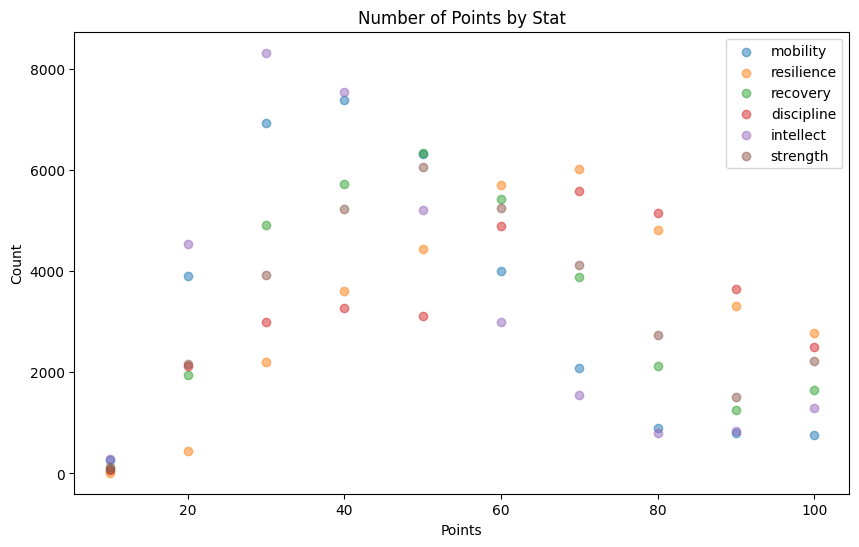

In [24]:
import matplotlib.pyplot as plt

# Reshape the DataFrame to long format
long_df = pinnacle_outfits_df.melt(
    value_vars=[
        "mobility",
        "resilience",
        "recovery",
        "discipline",
        "intellect",
        "strength",
    ],
)

# Rename the columns to 'stat' and 'points'
long_df = long_df.with_columns(
    long_df["variable"].alias("stat"),
    long_df["value"].alias("points"),
)

# Count the number of outfits for each point total for each stat
counts_df = long_df.group_by(["stat", "points"]).agg(pl.count("stat").alias("count"))

# Convert to pandas for easier plotting
counts_df = counts_df.to_pandas()

# Create a scatter plot
plt.figure(figsize=(10, 6))
for stat in [
    "mobility",
    "resilience",
    "recovery",
    "discipline",
    "intellect",
    "strength",
]:
    stat_df = counts_df[counts_df["stat"] == stat]
    plt.scatter(
        stat_df["points"],
        stat_df["count"],  # Y-axis
        alpha=0.5,
        label=stat,
    )
plt.xlabel("Points")
plt.ylabel("Count")
plt.title("Number of Points by Stat")
plt.legend()
plt.show()

### Scratch for testing specific outfits and comparing against DIM

In [26]:
def print_row_weighted_vs_max(row):
    # print the row so that we show the weighted value compared to the weighted max value
    row = row.to_dict()
    for key, value in row.items():
        if not (key.startswith("weighted_") or key.endswith("_max")):
            print(f"{key}: {value[0]}")
        if key.startswith("weighted_") and not key.endswith("_max"):
            max_key = key + "_max"
            real_value = value[0]
            max_value = row[max_key][0]
            if real_value == max_value:
                print(
                    f"{key}: {value[0]} == {row[max_key][0]} ************************************"
                )
            else:
                print(f"{key}: {value[0]} < {row[max_key][0]}")


def print_outfit_stats(row):
    helmet_id = row["helmet"][0]
    gauntlets_id = row["gauntlets"][0]
    chest_id = row["chest_armor"][0]
    leg_id = row["leg_armor"][0]
    class_item_id = row["class_item"][0]

    mobility = 0
    resilience = 0
    recovery = 0
    discipline = 0
    intellect = 0
    strength = 0

    for id in [helmet_id, gauntlets_id, chest_id, leg_id, class_item_id]:
        armor = armor_dict[id]
        mobility += armor.mobility
        resilience += armor.resilience
        recovery += armor.recovery
        discipline += armor.discipline
        intellect += armor.intellect
        strength += armor.strength
        print(
            f"{armor.mobility}\t{armor.resilience}\t{armor.recovery}\t{armor.discipline}\t{armor.intellect}\t{armor.strength}\t{armor.total_stats}\t{armor.is_artifice}\t{armor.item_name}\t{armor.instance_id}"
        )

    print(
        f"{mobility}\t{resilience}\t{recovery}\t{discipline}\t{intellect}\t{strength}\t<-- base outfit stats"
    )
    print(
        f"{row['mobility'][0]}\t{row['resilience'][0]}\t{row['recovery'][0]}\t{row['discipline'][0]}\t{row['intellect'][0]}\t{row['strength'][0]}\t<-- outfit with applied artifice + masterwork & rounded to useful tiers"
    )

In [27]:
# find rows in ploutfits_df that are duplicate rows for all fields - should not happen
pinnacle_outfits_df.filter(pinnacle_outfits_df.is_duplicated())

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max,total_stats
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64


In [34]:
# one of my specific outfits I can see in DIM - shows all permutations of this outfit that have unique stat totals
helmet_id = 6917529862437575151
gauntlets_id = 6917529838031225999
chest_id = 6917529838898582109
leg_id = 6917530017559101392
class_item_id = 6917529583788947730

outfit = weighted_outfits_df.filter(
    (weighted_outfits_df["helmet"] == helmet_id)
    & (weighted_outfits_df["gauntlets"] == gauntlets_id)
    & (weighted_outfits_df["chest_armor"] == chest_id)
    # & (weighted_outfits_df["leg_armor"] == leg_id)
    & (weighted_outfits_df["class_item"] == class_item_id)
)

# for i in range(outfit.height):
#     row = outfit[i]
#     print_outfit_stats(row)
#     print_row_weighted_vs_max(row)
outfit

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_intellect_max,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
40,90,20,90,30,30,6917529862437575151,6917529838031225999,6917529838898582109,6917529796979541985,6917529583788947730,2082483156,4,340,390,320,390,330,330,430,360,430,370,370,410,480,420,420,410,350,350,420,420,360,450,520,460,…,420,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500
40,100,20,90,30,30,6917529862437575151,6917529838031225999,6917529838898582109,6917529796979541985,6917529583788947730,2082483156,4,350,410,330,400,340,340,450,370,440,380,380,430,500,440,440,420,360,360,430,430,370,470,540,480,…,420,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500
40,90,20,90,30,40,6917529862437575151,6917529838031225999,6917529838898582109,6917529796979541985,6917529583788947730,2082483156,4,350,400,330,400,340,350,440,370,440,380,390,420,490,430,440,420,360,370,430,440,380,460,530,470,…,420,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500
40,100,20,90,40,30,6917529862437575151,6917529838031225999,6917529838898582109,6917529796979541985,6917529583788947730,2082483156,4,360,420,340,410,360,350,460,380,450,400,390,440,510,460,450,430,380,370,450,440,390,480,550,500,…,420,420,480,460,510,510,500,480,530,510,520,520,500,510,470,470,450,500,580,550,570,550,540,550,550,550,540,570,550,550,560,560,550,550,560,540,500
50,90,30,90